In [1]:
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
import sklearn.cross_validation as cross_validation
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import sklearn.tree as tree
import graphviz 
import pydotplus

from sklearn import model_selection
from sklearn.metrics import accuracy_score

C:\Users\zafri\Anaconda2\envs\py36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#FOR MODEL SELECTION
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV


In [3]:
import os
import pandas as pd
import numpy as np
import math 
import statsmodels as sm
import winsound
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Locate Data

In [4]:
cwd=os.getcwd()
print (cwd)

C:\Users\zafri\Documents\COGS 118A\final


In [5]:
def data_locate(rel_path_to_input,a):
    cwd = os.getcwd()
    stem=cwd
    for i in range(a):
        stem=os.path.abspath(os.path.join(stem, '..'))
    data_loc=os.path.join(stem , rel_path_to_input)
    os.chdir(data_loc)
    sub_files = os.listdir(data_loc)
    print ("Current Directory: ", cwd)
    print ("Data location: " , data_loc)
    print (sub_files)
    return data_loc, sub_files

In [6]:
data_loc, sub_files=data_locate("Datasets/Parkinsons", 0)

Current Directory:  C:\Users\zafri\Documents\COGS 118A\final
Data location:  C:\Users\zafri\Documents\COGS 118A\final\Datasets/Parkinsons
['data', 'data.csv', 'download_data', 'parkinsons.data.txt', 'parkinsons.names.txt', 'Parkinsons_OG_Data_results.csv', 'Parkinsons_OG_Data___20', 'Parkinsons_OG_Data___20.pdf', 'Parkinsons_OG_Data___50', 'Parkinsons_OG_Data___50.pdf', 'Parkinsons_OG_Data___80', 'Parkinsons_OG_Data___80.pdf']


In [7]:
control_data_path=os.path.join('data', 'control')
parkinson_data_path=os.path.join('data', 'parkinson')

In [8]:
control_file_list=[os.path.join(control_data_path, x) for x in os.listdir(control_data_path)]
parkinson_file_list=[os.path.join(parkinson_data_path, x) for x in os.listdir(parkinson_data_path)]

### Features
1. No of strokes
2. Stroke speed
3. Velocity
4. Acceleration
5. Jerk
6. Horizontal velocity/acceleration/jerk
7. Vertical velocity/acceleration/jerk
8. Number of changes in velocity direction
9. Number of changes in acceleration direction
10. Relative NCV
11. Relative NCA
12. in-air time
13. on-surface time
14. normalized in-air time
15. normalized on-surface time
16. in-air/on-surface ratio

## Feature Extraction

In [9]:
header_row=["X", "Y", "Z", "Pressure" , "GripAngle" , "Timestamp" , "Test_ID"]

In [10]:
#
def get_no_strokes(df):
    pressure_data=df['Pressure'].as_matrix()
    on_surface = (pressure_data>600).astype(int)
    return ((np.roll(on_surface, 1) - on_surface) != 0).astype(int).sum()

In [11]:
#
def get_speed(df):
    total_dist=0
    duration=df['Timestamp'].as_matrix()[-1]
    coords=df[['X', 'Y', 'Z']].as_matrix()
    for i in range(10, df.shape[0]):
        temp=np.linalg.norm(coords[i, :]-coords[i-10, :])
        total_dist+=temp
    speed=total_dist/duration
    return speed

In [12]:
#
def get_in_air_time(data):
    data=data['Pressure'].as_matrix()
    return (data<600).astype(int).sum()

In [13]:
#
def get_on_surface_time(data):
    data=data['Pressure'].as_matrix()
    return (data>600).astype(int).sum()

In [14]:
def find_velocity(f):
    '''
    change in direction and its position
    
    '''
    data_pat=f
    Vel = []
    horz_Vel = []
    horz_vel_mag = []
    vert_vel_mag = []
    vert_Vel = []
    magnitude = []
    timestamp_diff =  []
    
    t = 0
    for i in range(len(data_pat)-2):
        if t+10 <= len(data_pat)-1:
            Vel.append(((data_pat['X'].as_matrix()[t+10] - data_pat['X'].as_matrix()[t])/(data_pat['Timestamp'].as_matrix()[t+10]-data_pat['Timestamp'].as_matrix()[t]) , (data_pat['Y'].as_matrix()[t+10]-data_pat['Y'].as_matrix()[t])/(data_pat['Timestamp'].as_matrix()[t+10]-data_pat['Timestamp'].as_matrix()[t])))
            horz_Vel.append((data_pat['X'].as_matrix()[t+10] - data_pat['X'].as_matrix()[t])/(data_pat['Timestamp'].as_matrix()[t+10]-data_pat['Timestamp'].as_matrix()[t]))
            
            vert_Vel.append((data_pat['Y'].as_matrix()[t+10] - data_pat['Y'].as_matrix()[t])/(data_pat['Timestamp'].as_matrix()[t+10]-data_pat['Timestamp'].as_matrix()[t]))
            magnitude.append(sqrt(((data_pat['X'].as_matrix()[t+10]-data_pat['X'].as_matrix()[t])/(data_pat['Timestamp'].as_matrix()[t+10]-data_pat['Timestamp'].as_matrix()[t]))**2 + (((data_pat['Y'].as_matrix()[t+10]-data_pat['Y'].as_matrix()[t])/(data_pat['Timestamp'].as_matrix()[t+10]-data_pat['Timestamp'].as_matrix()[t]))**2)))
            timestamp_diff.append(data_pat['Timestamp'].as_matrix()[t+10]-data_pat['Timestamp'].as_matrix()[t])
            horz_vel_mag.append(abs(horz_Vel[len(horz_Vel)-1]))
            vert_vel_mag.append(abs(vert_Vel[len(vert_Vel)-1]))
            t = t+10
        else:
            break
    magnitude_vel = np.mean(magnitude)  
    magnitude_horz_vel = np.mean(horz_vel_mag)
    magnitude_vert_vel = np.mean(vert_vel_mag)
    return Vel,magnitude,timestamp_diff,horz_Vel,vert_Vel,magnitude_vel,magnitude_horz_vel,magnitude_vert_vel

In [15]:
def find_acceleration(f):
    '''
    change in direction and its velocity
   
    '''
    Vel,magnitude,timestamp_diff,horz_Vel,vert_Vel,magnitude_vel,magnitude_horz_vel,magnitude_vert_vel = find_velocity(f)
    accl = []
    horz_Accl =  []
    vert_Accl = []
    magnitude = []
    horz_acc_mag = []
    vert_acc_mag = []
    for i in range(len(Vel)-2):
        accl.append(((Vel[i+1][0]-Vel[i][0])/timestamp_diff[i] , (Vel[i+1][1]-Vel[i][1])/timestamp_diff[i]))
        horz_Accl.append((horz_Vel[i+1]-horz_Vel[i])/timestamp_diff[i])
        vert_Accl.append((vert_Vel[i+1]-vert_Vel[i])/timestamp_diff[i])
        horz_acc_mag.append(abs(horz_Accl[len(horz_Accl)-1]))
        vert_acc_mag.append(abs(vert_Accl[len(vert_Accl)-1]))
        magnitude.append(sqrt(((Vel[i+1][0]-Vel[i][0])/timestamp_diff[i])**2 + ((Vel[i+1][1]-Vel[i][1])/timestamp_diff[i])**2))
    
    magnitude_acc = np.mean(magnitude)  
    magnitude_horz_acc = np.mean(horz_acc_mag)
    magnitude_vert_acc = np.mean(vert_acc_mag)
    return accl,magnitude,horz_Accl,vert_Accl,timestamp_diff,magnitude_acc,magnitude_horz_acc,magnitude_vert_acc
    

In [16]:
def find_jerk(f):
    accl,magnitude,horz_Accl,vert_Accl,timestamp_diff,magnitude_acc,magnitude_horz_acc,magnitude_vert_acc = find_acceleration(f)
    jerk = []
    hrz_jerk = []
    vert_jerk = []
    magnitude = []
    horz_jerk_mag = []
    vert_jerk_mag = []
    
    for i in range(len(accl)-2):
        jerk.append(((accl[i+1][0]-accl[i][0])/timestamp_diff[i] , (accl[i+1][1]-accl[i][1])/timestamp_diff[i]))
        hrz_jerk.append((horz_Accl[i+1]-horz_Accl[i])/timestamp_diff[i])
        vert_jerk.append((vert_Accl[i+1]-vert_Accl[i])/timestamp_diff[i])
        horz_jerk_mag.append(abs(hrz_jerk[len(hrz_jerk)-1]))
        vert_jerk_mag.append(abs(vert_jerk[len(vert_jerk)-1]))
        magnitude.append(sqrt(((accl[i+1][0]-accl[i][0])/timestamp_diff[i])**2 + ((accl[i+1][1]-accl[i][1])/timestamp_diff[i])**2))
        
    magnitude_jerk = np.mean(magnitude)  
    magnitude_horz_jerk = np.mean(horz_jerk_mag)
    magnitude_vert_jerk = np.mean(vert_jerk_mag)
    return jerk,magnitude,hrz_jerk,vert_jerk,timestamp_diff,magnitude_jerk,magnitude_horz_jerk,magnitude_vert_jerk


In [17]:
def NCV_per_halfcircle(f):
    data_pat=f
    Vel = []
    ncv = []
    temp_ncv = 0
    basex = data_pat['X'].as_matrix()[0]
    for i in range(len(data_pat)-2):
        if data_pat['X'].as_matrix()[i] == basex:
            ncv.append(temp_ncv)
            temp_ncv = 0
            continue
            
        Vel.append(((data_pat['X'].as_matrix()[i+1] - data_pat['X'].as_matrix()[i])/(data_pat['Timestamp'].as_matrix()[i+1]-data_pat['Timestamp'].as_matrix()[i]) , (data_pat['Y'].as_matrix()[i+1]-data_pat['Y'].as_matrix()[i])/(data_pat['Timestamp'].as_matrix()[i+1]-data_pat['Timestamp'].as_matrix()[i])))
        if Vel[len(Vel)-1] != (0,0):
            temp_ncv+=1
    ncv.append(temp_ncv)
    #ncv = list(filter((2).__ne__, ncv))
    ncv_Val = np.sum(ncv)/np.count_nonzero(ncv)
    return ncv,ncv_Val

In [18]:
def NCA_per_halfcircle(f):
    data_pat=f
    Vel,magnitude,timestamp_diff,horz_Vel,vert_Vel,magnitude_vel,magnitude_horz_vel,magnitude_vert_vel = find_velocity(f)
    accl = []
    nca = []
    temp_nca = 0
    basex = data_pat['X'].as_matrix()[0]
    for i in range(len(Vel)-2):
        if data_pat['X'].as_matrix()[i] == basex:
            nca.append(temp_nca)
            #print ('tempNCa::',temp_nca)
            temp_nca = 0
            continue
            
        accl.append(((Vel[i+1][0]-Vel[i][0])/timestamp_diff[i] , (Vel[i+1][1]-Vel[i][1])/timestamp_diff[i]))
        if accl[len(accl)-1] != (0,0):
            temp_nca+=1
    nca.append(temp_nca)
    nca = list(filter((2).__ne__, nca))
    nca_Val = np.sum(nca)/np.count_nonzero(nca)
    return nca,nca_Val

In [19]:
#
def get_features(f, parkinson_target):
    global header_row
    df=pd.read_csv(f, sep=';', header=None, names=header_row)
    
    df_static=df[df["Test_ID"]==0]    # static test
    df_dynamic=df[df["Test_ID"]==1]    # dynamic test
    df_stcp=df[df["Test_ID"]==2]    # STCP
    #df_static_dynamic=pd.concat([df_static, df_dynamic])
    
    initial_timestamp=df['Timestamp'][0]
    df['Timestamp']=df['Timestamp']- initial_timestamp # offset timestamps
    
    duration_static = df_static['Timestamp'].as_matrix()[-1] if df_static.shape[0] else 1
    duration_dynamic = df_dynamic['Timestamp'].as_matrix()[-1] if df_dynamic.shape[0] else 1
    duration_STCP = df_stcp['Timestamp'].as_matrix()[-1] if df_stcp.shape[0] else 1

    
    data_point=[]
    data_point.append(get_no_strokes(df_static) if df_static.shape[0] else 0) # no. of strokes for static test
    data_point.append(get_no_strokes(df_dynamic) if df_dynamic.shape[0] else 0) # no. of strokes for dynamic test
    data_point.append(get_speed(df_static) if df_static.shape[0] else 0) # speed for static test
    data_point.append(get_speed(df_dynamic) if df_dynamic.shape[0] else 0) # speed for dynamic test

    Vel,magnitude,timestamp_diff,horz_Vel,vert_Vel,magnitude_vel,magnitude_horz_vel,magnitude_vert_vel = find_velocity(df_static) if df_static.shape[0] else (0,0,0,0,0,0,0,0) # magnitudes of velocity, horizontal velocity and vertical velocity for static test
    data_point.extend([magnitude_vel, magnitude_horz_vel,magnitude_vert_vel])
    Vel,magnitude,timestamp_diff,horz_Vel,vert_Vel,magnitude_vel,magnitude_horz_vel,magnitude_vert_vel = find_velocity(df_dynamic) if df_dynamic.shape[0] else (0,0,0,0,0,0,0,0) # magnitudes of velocity, horizontal velocity and vertical velocity for dynamic test
    data_point.extend([magnitude_vel, magnitude_horz_vel,magnitude_vert_vel])
    
    accl,magnitude,horz_Accl,vert_Accl,timestamp_diff,magnitude_acc,magnitude_horz_acc,magnitude_vert_acc=find_acceleration(df_static) if df_static.shape[0] else (0,0,0,0,0,0,0,0)# magnitudes of acceleration, horizontal acceleration and vertical acceleration for static test        
    data_point.extend([magnitude_acc,magnitude_horz_acc,magnitude_vert_acc])
    accl,magnitude,horz_Accl,vert_Accl,timestamp_diff,magnitude_acc,magnitude_horz_acc,magnitude_vert_acc=find_acceleration(df_dynamic) if df_dynamic.shape[0] else (0,0,0,0,0,0,0,0)# magnitudes of acceleration, horizontal acceleration and vertical acceleration for dynamic test        
    data_point.extend([magnitude_acc,magnitude_horz_acc,magnitude_vert_acc])
    
    jerk,magnitude,hrz_jerk,vert_jerk,timestamp_diff,magnitude_jerk,magnitude_horz_jerk,magnitude_vert_jerk=find_jerk(df_static) if df_static.shape[0] else (0,0,0,0,0,0,0,0) # magnitudes of jerk, horizontal jerk and vertical jerk for static test
    data_point.extend([magnitude_jerk,magnitude_horz_jerk,magnitude_vert_jerk])
    jerk,magnitude,hrz_jerk,vert_jerk,timestamp_diff,magnitude_jerk,magnitude_horz_jerk,magnitude_vert_jerk=find_jerk(df_dynamic) if df_dynamic.shape[0] else (0,0,0,0,0,0,0,0) # magnitudes of jerk, horizontal jerk and vertical jerk for dynamic test
    data_point.extend([magnitude_jerk,magnitude_horz_jerk,magnitude_vert_jerk])
    
    ncv,ncv_Val=NCV_per_halfcircle(df_static) if df_static.shape[0] else (0,0) # NCV for static test
    data_point.append(ncv_Val)
    ncv,ncv_Val=NCV_per_halfcircle(df_dynamic) if df_dynamic.shape[0] else (0,0) # NCV for dynamic test
    data_point.append(ncv_Val)
    
    nca,nca_Val=NCA_per_halfcircle(df_static) if df_static.shape[0] else (0,0) # NCA for static test
    data_point.append(nca_Val)
    nca,nca_Val=NCA_per_halfcircle(df_dynamic) if df_dynamic.shape[0] else (0,0) # NCA for dynamic test
    data_point.append(nca_Val)
    
    data_point.append(get_in_air_time(df_stcp) if df_stcp.shape[0] else 0) # in air time for STCP
    data_point.append(get_on_surface_time(df_static) if df_static.shape[0] else 0) # on surface time for static test
    data_point.append(get_on_surface_time(df_dynamic) if df_dynamic.shape[0] else 0) # on surface time for dynamic test
    
    data_point.append(parkinson_target)    # traget. 1 for parkinson. 0 for control.
    
    return data_point

In [20]:
temp_feat=get_features(parkinson_file_list[35], 1)

In [21]:
print(temp_feat)

[30, 72, 1.3588757917667431e-05, 2.623651083117971e-05, 0.12890441251529997, 0.08047123319627912, 0.08363708822986228, 0.1922934911107952, 0.11555023022027296, 0.1288027792221494, 0.0009161539523279476, 0.0005188222133507725, 0.0006655622008045722, 0.0010669055486579792, 0.0006104727526160723, 0.0007563033567564607, 2.2116391163746176e-05, 1.2543602500530039e-05, 1.646637220347185e-05, 2.250461762705396e-05, 1.3394439474233898e-05, 1.569201046814677e-05, 230.14285714285714, 269.8888888888889, 85.5, 86.66666666666667, 850, 524, 1230, 1]


In [22]:
raw=[]
for x in parkinson_file_list:
    raw.append(get_features(x, 1))
for x in control_file_list:
    raw.append(get_features(x, 0))

In [23]:
raw=np.array(raw)

In [24]:
features_headers=['no_strokes_st', 'no_strokes_dy', 'speed_st', 'speed_dy', 'magnitude_vel_st' , 'magnitude_horz_vel_st' , 'magnitude_vert_vel_st', 'magnitude_vel_dy', 'magnitude_horz_vel_dy' , 'magnitude_vert_vel_dy', 'magnitude_acc_st' , 'magnitude_horz_acc_st' , 'magnitude_vert_acc_st','magnitude_acc_dy' , 'magnitude_horz_acc_dy' , 'magnitude_vert_acc_dy', 'magnitude_jerk_st', 'magnitude_horz_jerk_st' , 'magnitude_vert_jerk_st', 'magnitude_jerk_dy', 'magnitude_horz_jerk_dy' , 'magnitude_vert_jerk_dy', 'ncv_st', 'ncv_dy', 'nca_st', 'nca_dy', 'in_air_stcp','on_surface_st', 'on_surface_dy', 'target']

# Parkinsons Movement Data Set 


In [25]:
Parkinsons_OG_Data=pd.DataFrame(raw, columns=features_headers)
DATASET='Parkinsons_OG_Data'

In [26]:
Parkinsons_OG_Data.tail()

,no_strokes_st,no_strokes_dy,speed_st,speed_dy,magnitude_vel_st,magnitude_horz_vel_st,magnitude_vert_vel_st,magnitude_vel_dy,magnitude_horz_vel_dy,magnitude_vert_vel_dy,...,magnitude_horz_jerk_dy,magnitude_vert_jerk_dy,ncv_st,ncv_dy,nca_st,nca_dy,in_air_stcp,on_surface_st,on_surface_dy,target
72,2.0,2.0,0.001592,0.001560,0.046842,0.029474,0.029731,0.042719,0.026828,0.026851,...,0.000004,0.000004,330.571429,324.571429,275.500000,282.000000,1536.0,5867.0,6558.0,0.0
73,2.0,2.0,0.001387,0.001339,0.088510,0.055965,0.055433,0.114583,0.073060,0.070357,...,0.000006,0.000005,224.222222,227.125000,71.500000,73.666667,1536.0,3029.0,2312.0,0.0
74,48.0,176.0,0.001201,0.001194,0.200499,0.124995,0.126018,0.175576,0.111122,0.109489,...,0.000007,0.000006,206.833333,276.400000,29.333333,74.500000,1536.0,572.0,575.0,0.0
75,6.0,10.0,0.001159,0.001157,0.150016,0.095055,0.095358,0.136387,0.090064,0.085038,...,0.000007,0.000005,189.125000,234.571429,14.000000,58.333333,1536.0,835.0,363.0,0.0
76,0.0,0.0,0.001152,0.001140,0.103493,0.066596,0.064488,0.106868,0.068777,0.067774,...,0.000005,0.000006,277.285714,266.285714,81.333333,117.000000,1536.0,0.0,0.0,0.0


In [27]:
Parkinsons_OG_Data.to_csv('data.csv')

#### Let's Peek at the Features

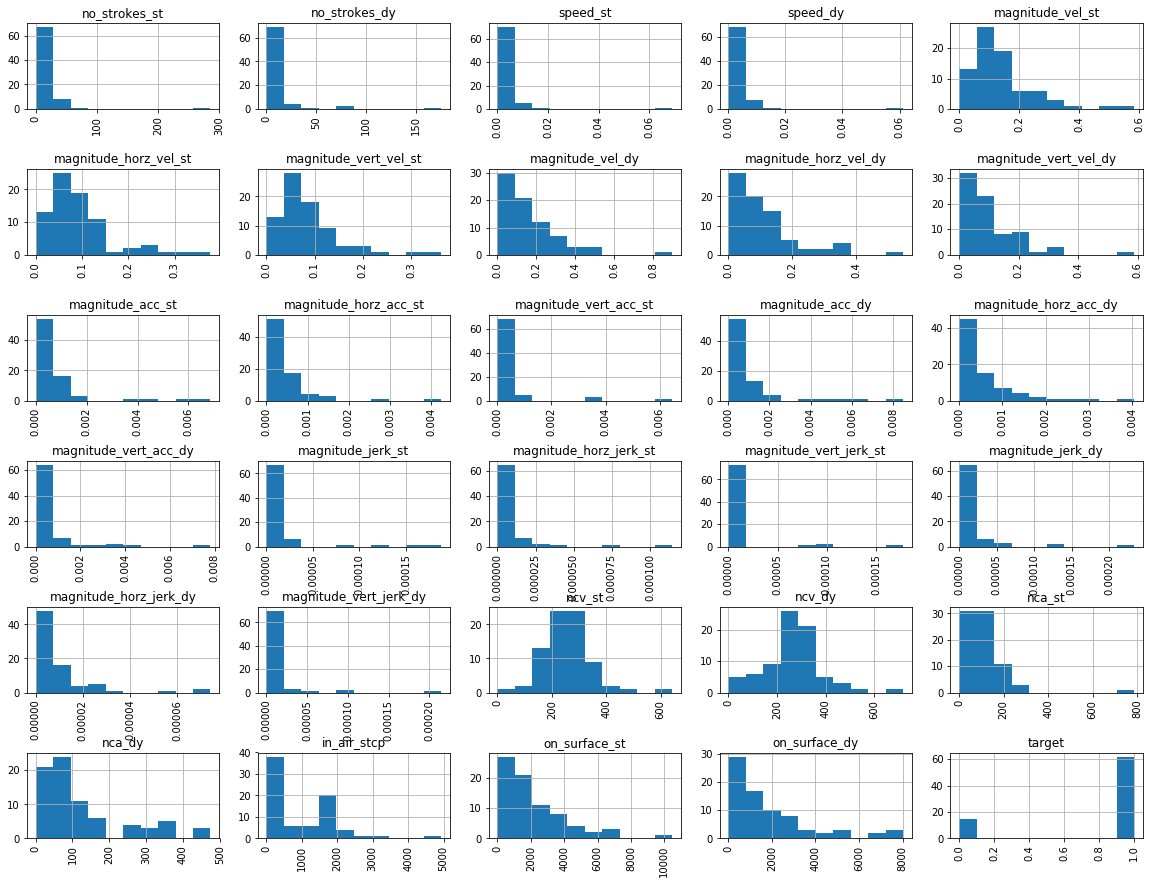

In [28]:
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(Parkinsons_OG_Data.shape[1]) / cols)
for i, column in enumerate(Parkinsons_OG_Data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if Parkinsons_OG_Data.dtypes[column] == np.object:
        Parkinsons_OG_Data[column].value_counts().plot(kind="bar", axes=ax)
    else:
        Parkinsons_OG_Data[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

#### Let's look at correlation between magnitude_horz_jerk and Class

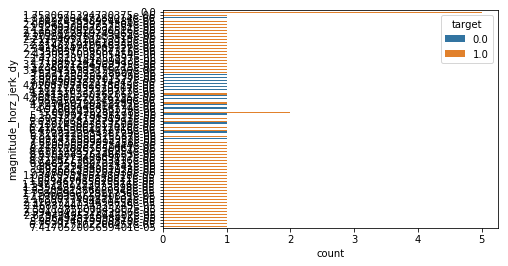

In [29]:
sns.countplot(y='magnitude_horz_jerk_dy', hue='target', data=Parkinsons_OG_Data)

#### Let's look at correlation between on surface st and Class

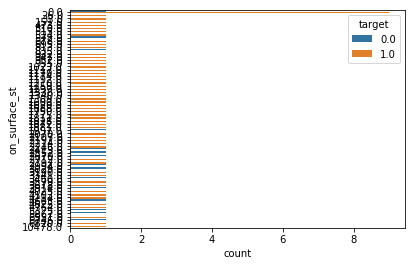

In [30]:
sns.countplot(y='on_surface_st', hue='target', data=Parkinsons_OG_Data)

#### Let's look at correlation across all variables


In [31]:
def plot_correlation(df, size=15):
    corr= df.corr()
    fig, ax =plt.subplots(figsize=(size,size))
    cax=ax.matshow(corr, cmap='GnBu')
    plt.xticks(range(len(corr.columns)),corr.columns)
    plt.yticks(range(len(corr.columns)),corr.columns)
    plt.colorbar(cax)
    plt.show()

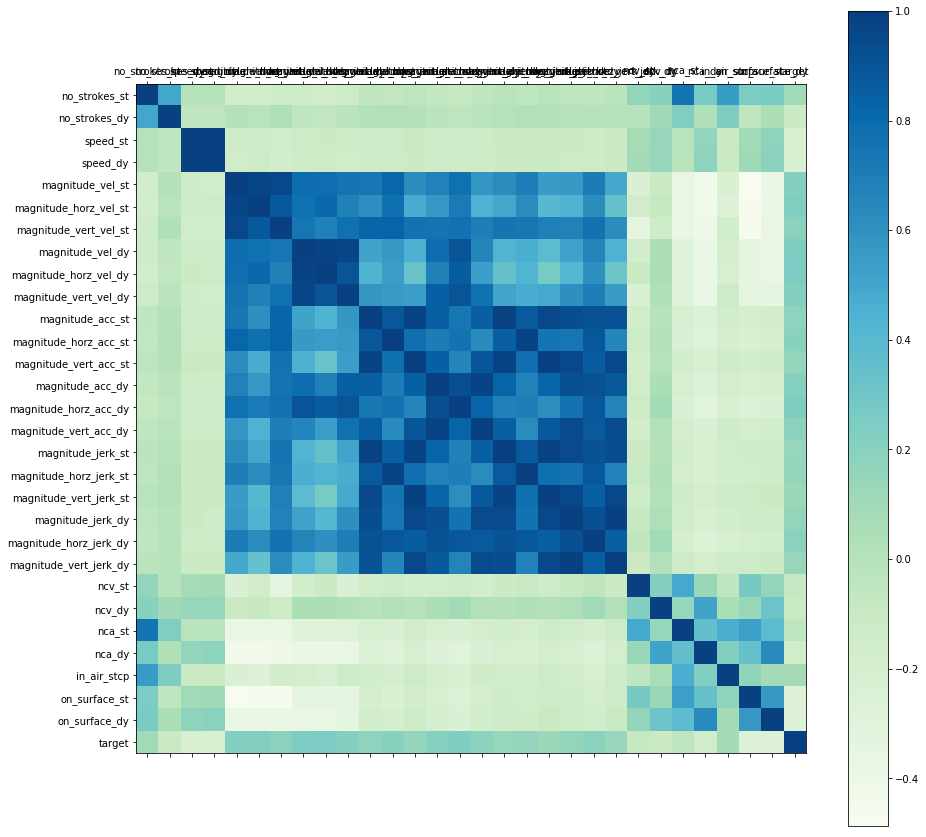

In [32]:
plot_correlation(Parkinsons_OG_Data, size=15 )

# Let's Clean up the data


In [33]:
# Let's Clean up the data
NAN_index_list=Parkinsons_OG_Data[Parkinsons_OG_Data.isnull().any(axis=1)].index
len(NAN_index_list)

0

_____________________________________________________________________________________________________________
# Functions
_____________________________________________________________________________________________________________

In [34]:
#SPLIT DATA INTO TEST AND TRAINVAL
def split_Data_TV_Test(df,class_col, test_):
    X= df.drop([str(class_col)],axis=1)
    Y=df[str(class_col)]
    
    test_split_size=test_
    #Creation of Train and Test dataset
    X_TV, X_test, y_TV, y_test = train_test_split(X,Y,test_size=test_split_size,random_state=22)
    train_=round((1-test_)*100)
    print ("Train: {0}% Test: {1}%".format(train_,(test_*100)))
    print ("Train/Validation dataset: {0}  {1}".format(X_TV.shape, y_TV.shape))
    print ("Test dataset: {0}  {1}".format(X_test.shape, y_test.shape))
    return X_TV, X_test, y_TV, y_test, train_

In [35]:
#SPLIT DATA INTO TRAIN AND VAL
def split_Data_T_V_(X_tv, y_tv, val_):
    val_split_size=val_
    #Creation of Train and Test dataset
    X_Tr, X_val, y_Tr, y_val = train_test_split(X_tv,y_tv,test_size=val_split_size,random_state=22)
   
    print ("Train: {0}% Validation: {1}%".format(round((1-val_)*100),(val_*100)))
    print ("Train dataset: {0}  {1}".format(X_Tr.shape, y_Tr.shape))
    print ("Validation dataset: {0}  {1}".format(X_val.shape, y_val.shape))

    return X_Tr, X_val, y_Tr, y_val

In [36]:
def Model_Selection(X_TV, y_TV, val_):
    models = []
    names = ['LR','Random Forest','Neural Network','GaussianNB','DecisionTreeClassifier','SVM',]

    models.append((LogisticRegression()))
    models.append((RandomForestClassifier(n_estimators=100)))
    models.append((MLPClassifier()))
    models.append((GaussianNB()))
    models.append((DecisionTreeClassifier()))
    models.append((SVC()))




    X_Tr, X_val, y_Tr, y_val=split_Data_T_V_(X_TV, y_TV, val_)
    rand_ints=[35,56,82]
    for r in range(len(rand_ints)):
        kfold = model_selection.KFold(n_splits=5,random_state=rand_ints[r])
        print ('-'*40)
        print ('Random kfold selection #{0}'.format(r+1))

        for i in range(0,len(models)):    
            cv_result = model_selection.cross_val_score(models[i],X_Tr,y_Tr,cv=kfold,scoring='accuracy')
            score=models[i].fit(X_Tr,y_Tr)
            prediction = models[i].predict(X_val)
            acc_score = accuracy_score(y_val,prediction)     
        
            print ('{0}: {1}'.format(names[i],acc_score))

    duration = 1000  # millisecond
    freq = 500  # Hz
    winsound.Beep(freq, duration)

In [37]:
def Linear_SVM_GRID_Search(DATASET, df,class_col, test_):
    X_TV, X_test, y_TV, y_test, train_ =split_Data_TV_Test(df,class_col, test_)
    #3 Trials
    tuned_parameters = [{'kernel': ['linear'],'C': [10**-3,10**-1,1,10,100]},
                        {'kernel': ['linear'],'C': [10**-3,10**-1,1,10,100]},
                        {'kernel': ['linear'],'C': [10**-3,10**-1,1,10,100]}]
    #Accuracy optimized
    #Cross Validation=3
    scores = 'accuracy'
    c=0
    data_all=[]
    for parameter in tuned_parameters:
        print("# Tuning hyper-parameters for %s" % scores)
        print()

        clf = GridSearchCV(svm.SVC(), parameter, cv=3,scoring=scores)
        clf.fit(X_TV, y_TV)
        c+=1
    
    
        print("Trial # {0}".format(c))
        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        
        #write data to a CSV 
        #outputs 
        
        # DF | Train % | Test % 
        row1=[DATASET, train_, test_ ]
        #TV | Len(X_TV) | Len(y_TV)
        row2=[ "Training/Validation", "#TV Feature Samples", "#TV Class Labels"]
        row3=[ "",X_TV.shape, y_TV.shape ]

        #Test | Len(X_Test) | Len(y_Test)
        row4=[ "Test", "#Test Feature Samples", "#Test Class Labels"]
        row5=[ "",X_test.shape, y_test.shape ]
        #Trial #         #Best Parameter: 
        row6=['Trial/ Best Parameter', c, clf.best_params_]
        #Grid Scores=
        
        Grid_of_scores=[]
        row7=["Training Accuracies","_","_"]
        row8=["Mean", "Standard Deviation", "Parameter"]
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
            Grid_of_scores.append([mean, std * 2, params])
        
        data=[row1, row2, row3, row4,row5, row6, row7, row8]
        for i in data:
            data_all.append(i)
        for i in Grid_of_scores:
            data_all.append(i) 
            
        #SAVE RESULTS
    output=pd.DataFrame(data=data_all)
        
    return output

In [38]:
def Linear_SVM_TEST(DATASET,X_TV, y_TV, X_test, y_test, best_param, Accuracies_DF):
    clf =svm.SVC(kernel='linear', C=best_param)
    clf.fit(X_TV, y_TV)
    y_pred=clf.predict(X_test)
    Test_accuracy=(accuracy_score(y_test, y_pred, normalize=False))/(len(y_test))
    print (Test_accuracy)
    num=[len(Accuracies_DF)]
    df3 = pd.DataFrame({0: "Test Accuracy",
                        1: Test_accuracy , 
                        2: "_____________"}, index=[num])
    
    
    Accuracies_DF=Accuracies_DF.append(df3)
    return Accuracies_DF

In [39]:
def Decision_Tree_GRID_Search(DATASET, df,class_col, test_):
    X_TV, X_test, y_TV, y_test, train_ =split_Data_TV_Test(df,class_col, test_)
    #3 Trials
    tuned_parameters = [{'max_depth': (3, 5, 7)},
                        {'max_depth': (3, 5, 7)},
                        {'max_depth': (3, 5, 7)}]
    
    #Accuracy optimized
    #Cross Validation=3
    scores = 'accuracy'
    c=0
    data_all=[]
    for parameter in tuned_parameters:
        print("# Tuning hyper-parameters for %s" % scores)
        print()

        clf = GridSearchCV(tree.DecisionTreeClassifier(), parameter, cv=3,scoring=scores)
        clf.fit(X_TV, y_TV)
        c+=1
    
    
        print("Trial # {0}".format(c))
        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        
         #write data to a CSV 
        #outputs 
        
        # DF | Train % | Test % 
        row1=[DATASET, train_, test_ ]
        #TV | Len(X_TV) | Len(y_TV)
        row2=[ "Training/Validation", "#TV Feature Samples", "#TV Class Labels"]
        row3=[ "",X_TV.shape, y_TV.shape ]

        #Test | Len(X_Test) | Len(y_Test)
        row4=[ "Test", "#Test Feature Samples", "#Test Class Labels"]
        row5=[ "",X_test.shape, y_test.shape ]
        #Trial #         #Best Parameter: 
        row6=['Trial/ Best Parameter', c, clf.best_params_]
        #Grid Scores=
        
        Grid_of_scores=[]
        row7=["Training Accuracies","_","_"]
        row8=["Mean", "Standard Deviation", "Parameter"]
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
            Grid_of_scores.append([mean, std * 2, params])
        
        data=[row1, row2, row3, row4,row5, row6, row7, row8]
        for i in data:
            data_all.append(i)
        for i in Grid_of_scores:
            data_all.append(i) 
            
        #SAVE RESULTS
    output=pd.DataFrame(data=data_all)
        
    return output

In [40]:
def Decision_Tree_TEST(DATASET,df,train_, X_TV, y_TV, X_test, y_test, best_param, Accuracies_DF):
    
    
    labels=Parkinsons_OG_Data.columns
    labels=labels.drop("target")
    
    clf =tree.DecisionTreeClassifier(max_depth=best_param)
    clf.fit(X_TV, y_TV) 
    
    
    dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=labels,  
                         class_names=['open','close'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = graphviz.Source(dot_data)  
    graph.render(str(DATASET)+'___'+str(train_))
    
    y_pred=clf.predict(X_test)
    Test_accuracy=(accuracy_score(y_test, y_pred, normalize=False))/(len(y_test))
    print (Test_accuracy)
    
    
    num=[len(Accuracies_DF)]
    df3 = pd.DataFrame({0: "Test Accuracy",
                        1: Test_accuracy , 
                        2: "_____________"}, index=[num])
    
    
    Accuracies_DF=Accuracies_DF.append(df3)
    return Accuracies_DF

In [41]:
def Random_Forest_GRID_Search(DATASET, df,class_col, test_):
    X_TV, X_test, y_TV, y_test, train_ =split_Data_TV_Test(df,class_col, test_)
    #3 Trials
    tuned_parameters = [{'max_depth': range(1,10,2), 'n_estimators':(10,50,100)},
                        {'max_depth': range(1,10,2), 'n_estimators':(10,50,100)},
                        {'max_depth': range(1,10,2), 'n_estimators':(10,50,100)}]
    
    #Accuracy optimized
    #Cross Validation=3
    scores = 'accuracy'
    c=0
    data_all=[]
    for parameter in tuned_parameters:
        print("# Tuning hyper-parameters for %s" % scores)
        print()

        clf = GridSearchCV(RandomForestClassifier(), parameter, cv=3,scoring=scores)
        clf.fit(X_TV, y_TV)
        c+=1
    
    
        print("Trial # {0}".format(c))
        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        
         #write data to a CSV 
        #outputs 
        
        # DF | Train % | Test % 
        row1=[DATASET, train_, test_ ]
        #TV | Len(X_TV) | Len(y_TV)
        row2=[ "Training/Validation", "#TV Feature Samples", "#TV Class Labels"]
        row3=[ "",X_TV.shape, y_TV.shape ]

        #Test | Len(X_Test) | Len(y_Test)
        row4=[ "Test", "#Test Feature Samples", "#Test Class Labels"]
        row5=[ "",X_test.shape, y_test.shape ]
        #Trial #         #Best Parameter: 
        row6=['Trial/ Best Parameter', c, clf.best_params_]
        #Grid Scores=
        
        Grid_of_scores=[]
        row7=["Training Accuracies","_","_"]
        row8=["Mean", "Standard Deviation", "Parameter"]
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
            Grid_of_scores.append([mean, std * 2, params])
        
        data=[row1, row2, row3, row4,row5, row6, row7, row8]
        for i in data:
            data_all.append(i)
        for i in Grid_of_scores:
            data_all.append(i) 
            
        #SAVE RESULTS
    output=pd.DataFrame(data=data_all)
        
    return output

In [42]:
def Random_Forest_TEST(DATASET,X_TV, y_TV, X_test, y_test, Best_depth, Best_n, Accuracies_DF):
    clf =RandomForestClassifier(max_depth=Best_depth, n_estimators=Best_n)
    clf.fit(X_TV, y_TV)
    y_pred=clf.predict(X_test)
    Test_accuracy=(accuracy_score(y_test, y_pred, normalize=False))/(len(y_test))
    print (Test_accuracy)
    num=[len(Accuracies_DF)]
    df3 = pd.DataFrame({0: "Test Accuracy",
                        1: Test_accuracy , 
                        2: "_____________"}, index=[num])
    
    
    Accuracies_DF=Accuracies_DF.append(df3)
    return Accuracies_DF



### Splits include 
    - 20% TV, 80% Test
    - 50% TV, 50% Test
    - 80% TV, 20% Test
    
# Split 1 : 20% Train, 80% Test    

In [43]:
X_TV, X_test, y_TV, y_test, train_ =split_Data_TV_Test(Parkinsons_OG_Data, "target" , .8)

Train: 20% Test: 80.0%
Train/Validation dataset: (15, 29)  (15,)
Test dataset: (62, 29)  (62,)


#### Model Selection 

Lets see how different classifiers perform on set

k-fold implementation (k=3)

In [44]:
#val_=.25 
Model_Selection(X_TV, y_TV, .25)

Train: 75% Validation: 25.0%
Train dataset: (11, 29)  (11,)
Validation dataset: (4, 29)  (4,)
----------------------------------------
Random kfold selection #1
LR: 0.5
Random Forest: 1.0
Neural Network: 1.0
GaussianNB: 0.75
DecisionTreeClassifier: 0.5
SVM: 1.0
----------------------------------------
Random kfold selection #2
LR: 0.5
Random Forest: 1.0
Neural Network: 1.0
GaussianNB: 0.75
DecisionTreeClassifier: 0.5
SVM: 1.0
----------------------------------------
Random kfold selection #3
LR: 0.5
Random Forest: 1.0
Neural Network: 0.0
GaussianNB: 0.75
DecisionTreeClassifier: 0.25
SVM: 1.0


  #### Linear SVM
  
  <p> Implementation using sklearn svm.SVC(Kernel='Linear') </p>

In [45]:
SP1_SVM_Accuracies_DF=Linear_SVM_GRID_Search(DATASET, Parkinsons_OG_Data,"target", .8)

Train: 20% Test: 80.0%
Train/Validation dataset: (15, 29)  (15,)
Test dataset: (62, 29)  (62,)
# Tuning hyper-parameters for accuracy

Trial # 1
Best parameters set found on development set:

{'C': 0.001, 'kernel': 'linear'}

Grid scores on development set:

0.800 (+/-0.067) for {'C': 0.001, 'kernel': 'linear'}
0.800 (+/-0.067) for {'C': 0.1, 'kernel': 'linear'}
0.800 (+/-0.067) for {'C': 1, 'kernel': 'linear'}
0.800 (+/-0.067) for {'C': 10, 'kernel': 'linear'}
0.800 (+/-0.067) for {'C': 100, 'kernel': 'linear'}
# Tuning hyper-parameters for accuracy

Trial # 2
Best parameters set found on development set:

{'C': 0.001, 'kernel': 'linear'}

Grid scores on development set:

0.800 (+/-0.067) for {'C': 0.001, 'kernel': 'linear'}
0.800 (+/-0.067) for {'C': 0.1, 'kernel': 'linear'}
0.800 (+/-0.067) for {'C': 1, 'kernel': 'linear'}
0.800 (+/-0.067) for {'C': 10, 'kernel': 'linear'}
0.800 (+/-0.067) for {'C': 100, 'kernel': 'linear'}
# Tuning hyper-parameters for accuracy

Trial # 3
Best para

C:\Users\zafri\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\zafri\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\zafri\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


In [46]:
SP1_SVM_Accuracies_DF=Linear_SVM_TEST(DATASET,X_TV, y_TV, X_test, y_test, 0.001 , SP1_SVM_Accuracies_DF)

0.6935483870967742


#### Decision Tree

In [47]:
SP1_Decision_Tree_Accuracies_DF=Decision_Tree_GRID_Search(DATASET, Parkinsons_OG_Data,"target", .8)

Train: 20% Test: 80.0%
Train/Validation dataset: (15, 29)  (15,)
Test dataset: (62, 29)  (62,)
# Tuning hyper-parameters for accuracy

Trial # 1
Best parameters set found on development set:

{'max_depth': 3}

Grid scores on development set:

0.800 (+/-0.313) for {'max_depth': 3}
0.733 (+/-0.200) for {'max_depth': 5}
0.733 (+/-0.200) for {'max_depth': 7}
# Tuning hyper-parameters for accuracy

Trial # 2
Best parameters set found on development set:

{'max_depth': 3}

Grid scores on development set:

0.800 (+/-0.313) for {'max_depth': 3}
0.800 (+/-0.313) for {'max_depth': 5}
0.800 (+/-0.313) for {'max_depth': 7}
# Tuning hyper-parameters for accuracy

Trial # 3
Best parameters set found on development set:

{'max_depth': 3}

Grid scores on development set:

0.733 (+/-0.200) for {'max_depth': 3}
0.733 (+/-0.200) for {'max_depth': 5}
0.733 (+/-0.200) for {'max_depth': 7}


C:\Users\zafri\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\zafri\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\zafri\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


In [48]:
SP1_Decision_Tree_Accuracies_DF=Decision_Tree_TEST(DATASET,Parkinsons_OG_Data, train_, X_TV, y_TV, X_test, y_test, 3 , SP1_Decision_Tree_Accuracies_DF)

0.6451612903225806


#### Random Forest


In [49]:
SP1_Random_Forest_Accuracies_DF=Random_Forest_GRID_Search(DATASET, Parkinsons_OG_Data, 'target', .8)

Train: 20% Test: 80.0%
Train/Validation dataset: (15, 29)  (15,)
Test dataset: (62, 29)  (62,)
# Tuning hyper-parameters for accuracy



C:\Users\zafri\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Trial # 1
Best parameters set found on development set:

{'max_depth': 1, 'n_estimators': 10}

Grid scores on development set:

0.867 (+/-0.163) for {'max_depth': 1, 'n_estimators': 10}
0.867 (+/-0.163) for {'max_depth': 1, 'n_estimators': 50}
0.867 (+/-0.163) for {'max_depth': 1, 'n_estimators': 100}
0.867 (+/-0.163) for {'max_depth': 3, 'n_estimators': 10}
0.867 (+/-0.163) for {'max_depth': 3, 'n_estimators': 50}
0.867 (+/-0.163) for {'max_depth': 3, 'n_estimators': 100}
0.867 (+/-0.163) for {'max_depth': 5, 'n_estimators': 10}
0.867 (+/-0.163) for {'max_depth': 5, 'n_estimators': 50}
0.867 (+/-0.163) for {'max_depth': 5, 'n_estimators': 100}
0.800 (+/-0.067) for {'max_depth': 7, 'n_estimators': 10}
0.867 (+/-0.163) for {'max_depth': 7, 'n_estimators': 50}
0.867 (+/-0.163) for {'max_depth': 7, 'n_estimators': 100}
0.867 (+/-0.163) for {'max_depth': 9, 'n_estimators': 10}
0.867 (+/-0.163) for {'max_depth': 9, 'n_estimators': 50}
0.867 (+/-0.163) for {'max_depth': 9, 'n_estimators': 10

C:\Users\zafri\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Trial # 2
Best parameters set found on development set:

{'max_depth': 1, 'n_estimators': 10}

Grid scores on development set:

0.867 (+/-0.163) for {'max_depth': 1, 'n_estimators': 10}
0.867 (+/-0.163) for {'max_depth': 1, 'n_estimators': 50}
0.867 (+/-0.163) for {'max_depth': 1, 'n_estimators': 100}
0.867 (+/-0.163) for {'max_depth': 3, 'n_estimators': 10}
0.867 (+/-0.163) for {'max_depth': 3, 'n_estimators': 50}
0.867 (+/-0.163) for {'max_depth': 3, 'n_estimators': 100}
0.733 (+/-0.200) for {'max_depth': 5, 'n_estimators': 10}
0.867 (+/-0.163) for {'max_depth': 5, 'n_estimators': 50}
0.867 (+/-0.163) for {'max_depth': 5, 'n_estimators': 100}
0.800 (+/-0.067) for {'max_depth': 7, 'n_estimators': 10}
0.867 (+/-0.163) for {'max_depth': 7, 'n_estimators': 50}
0.867 (+/-0.163) for {'max_depth': 7, 'n_estimators': 100}
0.867 (+/-0.163) for {'max_depth': 9, 'n_estimators': 10}
0.867 (+/-0.163) for {'max_depth': 9, 'n_estimators': 50}
0.867 (+/-0.163) for {'max_depth': 9, 'n_estimators': 10

C:\Users\zafri\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Trial # 3
Best parameters set found on development set:

{'max_depth': 1, 'n_estimators': 10}

Grid scores on development set:

0.867 (+/-0.163) for {'max_depth': 1, 'n_estimators': 10}
0.867 (+/-0.163) for {'max_depth': 1, 'n_estimators': 50}
0.867 (+/-0.163) for {'max_depth': 1, 'n_estimators': 100}
0.733 (+/-0.283) for {'max_depth': 3, 'n_estimators': 10}
0.867 (+/-0.163) for {'max_depth': 3, 'n_estimators': 50}
0.867 (+/-0.163) for {'max_depth': 3, 'n_estimators': 100}
0.867 (+/-0.163) for {'max_depth': 5, 'n_estimators': 10}
0.867 (+/-0.163) for {'max_depth': 5, 'n_estimators': 50}
0.867 (+/-0.163) for {'max_depth': 5, 'n_estimators': 100}
0.867 (+/-0.163) for {'max_depth': 7, 'n_estimators': 10}
0.867 (+/-0.163) for {'max_depth': 7, 'n_estimators': 50}
0.867 (+/-0.163) for {'max_depth': 7, 'n_estimators': 100}
0.733 (+/-0.283) for {'max_depth': 9, 'n_estimators': 10}
0.867 (+/-0.163) for {'max_depth': 9, 'n_estimators': 50}
0.867 (+/-0.163) for {'max_depth': 9, 'n_estimators': 10

In [50]:
SP1_Random_Forest_Accuracies_DF=Random_Forest_TEST(DATASET,X_TV, y_TV, X_test, y_test, 1, 50 , SP1_Random_Forest_Accuracies_DF)

0.7903225806451613


# Split 2 : 50% Train, 50% Test    

In [51]:
X_TV, X_test, y_TV, y_test, train_ =split_Data_TV_Test(Parkinsons_OG_Data, "target" , .5)

Train: 50% Test: 50.0%
Train/Validation dataset: (38, 29)  (38,)
Test dataset: (39, 29)  (39,)


#### Model Selection 

Lets see how different classifiers perform on set

k-fold implementation (k=3)

In [52]:
#val_=.25 
Model_Selection(X_TV, y_TV, .25)

Train: 75% Validation: 25.0%
Train dataset: (28, 29)  (28,)
Validation dataset: (10, 29)  (10,)
----------------------------------------
Random kfold selection #1
LR: 0.7
Random Forest: 0.7
Neural Network: 0.5
GaussianNB: 0.7
DecisionTreeClassifier: 0.7
SVM: 0.6
----------------------------------------
Random kfold selection #2
LR: 0.7
Random Forest: 0.7
Neural Network: 0.6
GaussianNB: 0.7
DecisionTreeClassifier: 0.7
SVM: 0.6
----------------------------------------
Random kfold selection #3
LR: 0.7
Random Forest: 0.7
Neural Network: 0.6
GaussianNB: 0.7
DecisionTreeClassifier: 0.7
SVM: 0.6


  #### Linear SVM
  
  <p> Implementation using sklearn svm.SVC(Kernel='Linear') </p>

In [53]:
SP2_SVM_Accuracies_DF=Linear_SVM_GRID_Search(DATASET, Parkinsons_OG_Data,"target", .5)

Train: 50% Test: 50.0%
Train/Validation dataset: (38, 29)  (38,)
Test dataset: (39, 29)  (39,)
# Tuning hyper-parameters for accuracy

Trial # 1
Best parameters set found on development set:

{'C': 0.001, 'kernel': 'linear'}

Grid scores on development set:

0.684 (+/-0.289) for {'C': 0.001, 'kernel': 'linear'}
0.658 (+/-0.148) for {'C': 0.1, 'kernel': 'linear'}
0.605 (+/-0.205) for {'C': 1, 'kernel': 'linear'}
0.579 (+/-0.265) for {'C': 10, 'kernel': 'linear'}
0.605 (+/-0.205) for {'C': 100, 'kernel': 'linear'}
# Tuning hyper-parameters for accuracy

Trial # 2
Best parameters set found on development set:

{'C': 0.001, 'kernel': 'linear'}

Grid scores on development set:

0.684 (+/-0.289) for {'C': 0.001, 'kernel': 'linear'}
0.658 (+/-0.148) for {'C': 0.1, 'kernel': 'linear'}
0.605 (+/-0.205) for {'C': 1, 'kernel': 'linear'}
0.579 (+/-0.265) for {'C': 10, 'kernel': 'linear'}
0.605 (+/-0.205) for {'C': 100, 'kernel': 'linear'}
# Tuning hyper-parameters for accuracy

Trial # 3
Best para

In [54]:
SP2_SVM_Accuracies_DF=Linear_SVM_TEST(DATASET,X_TV, y_TV, X_test, y_test, 0.001 , SP2_SVM_Accuracies_DF)

0.7435897435897436


#### Decision Tree

In [55]:
SP2_Decision_Tree_Accuracies_DF=Decision_Tree_GRID_Search(DATASET, Parkinsons_OG_Data,"target", .5)

Train: 50% Test: 50.0%
Train/Validation dataset: (38, 29)  (38,)
Test dataset: (39, 29)  (39,)
# Tuning hyper-parameters for accuracy

Trial # 1
Best parameters set found on development set:

{'max_depth': 3}

Grid scores on development set:

0.789 (+/-0.175) for {'max_depth': 3}
0.711 (+/-0.066) for {'max_depth': 5}
0.737 (+/-0.137) for {'max_depth': 7}
# Tuning hyper-parameters for accuracy

Trial # 2
Best parameters set found on development set:

{'max_depth': 3}

Grid scores on development set:

0.763 (+/-0.100) for {'max_depth': 3}
0.684 (+/-0.217) for {'max_depth': 5}
0.763 (+/-0.100) for {'max_depth': 7}
# Tuning hyper-parameters for accuracy

Trial # 3
Best parameters set found on development set:

{'max_depth': 3}

Grid scores on development set:

0.789 (+/-0.066) for {'max_depth': 3}
0.789 (+/-0.066) for {'max_depth': 5}
0.763 (+/-0.100) for {'max_depth': 7}


In [56]:
SP2_Decision_Tree_Accuracies_DF=Decision_Tree_TEST(DATASET,Parkinsons_OG_Data, train_, X_TV, y_TV, X_test, y_test, 7 , SP2_Decision_Tree_Accuracies_DF)

0.8205128205128205


#### Random Forest


In [57]:
SP2_Random_Forest_Accuracies_DF=Random_Forest_GRID_Search(DATASET, Parkinsons_OG_Data, 'target', .5)

Train: 50% Test: 50.0%
Train/Validation dataset: (38, 29)  (38,)
Test dataset: (39, 29)  (39,)
# Tuning hyper-parameters for accuracy

Trial # 1
Best parameters set found on development set:

{'max_depth': 5, 'n_estimators': 10}

Grid scores on development set:

0.842 (+/-0.109) for {'max_depth': 1, 'n_estimators': 10}
0.842 (+/-0.109) for {'max_depth': 1, 'n_estimators': 50}
0.816 (+/-0.046) for {'max_depth': 1, 'n_estimators': 100}
0.789 (+/-0.234) for {'max_depth': 3, 'n_estimators': 10}
0.842 (+/-0.109) for {'max_depth': 3, 'n_estimators': 50}
0.895 (+/-0.084) for {'max_depth': 3, 'n_estimators': 100}
0.921 (+/-0.011) for {'max_depth': 5, 'n_estimators': 10}
0.895 (+/-0.084) for {'max_depth': 5, 'n_estimators': 50}
0.868 (+/-0.068) for {'max_depth': 5, 'n_estimators': 100}
0.789 (+/-0.103) for {'max_depth': 7, 'n_estimators': 10}
0.868 (+/-0.092) for {'max_depth': 7, 'n_estimators': 50}
0.868 (+/-0.068) for {'max_depth': 7, 'n_estimators': 100}
0.842 (+/-0.109) for {'max_depth': 9,

In [58]:
SP2_Random_Forest_Accuracies_DF=Random_Forest_TEST(DATASET,X_TV, y_TV, X_test, y_test, 3, 50 , SP2_Random_Forest_Accuracies_DF)

0.8717948717948718


# Split 3 : 80% Train, 20% Test    

In [59]:
X_TV, X_test, y_TV, y_test, train_ =split_Data_TV_Test(Parkinsons_OG_Data, "target" , .2)

Train: 80% Test: 20.0%
Train/Validation dataset: (61, 29)  (61,)
Test dataset: (16, 29)  (16,)


#### Model Selection 

Lets see how different classifiers perform on set

k-fold implementation (k=3)

In [60]:
#val_=.25 
Model_Selection(X_TV, y_TV, .25)

Train: 75% Validation: 25.0%
Train dataset: (45, 29)  (45,)
Validation dataset: (16, 29)  (16,)
----------------------------------------
Random kfold selection #1
LR: 0.75
Random Forest: 0.8125
Neural Network: 0.8125
GaussianNB: 0.875
DecisionTreeClassifier: 0.75
SVM: 0.75
----------------------------------------
Random kfold selection #2
LR: 0.75
Random Forest: 0.8125
Neural Network: 0.5
GaussianNB: 0.875
DecisionTreeClassifier: 0.625
SVM: 0.75
----------------------------------------
Random kfold selection #3
LR: 0.75
Random Forest: 0.8125
Neural Network: 0.75
GaussianNB: 0.875
DecisionTreeClassifier: 0.75
SVM: 0.75


  #### Linear SVM
  
  <p> Implementation using sklearn svm.SVC(Kernel='Linear') </p>

In [61]:
SP3_SVM_Accuracies_DF=Linear_SVM_GRID_Search(DATASET, Parkinsons_OG_Data,"target", .2)

Train: 80% Test: 20.0%
Train/Validation dataset: (61, 29)  (61,)
Test dataset: (16, 29)  (16,)
# Tuning hyper-parameters for accuracy

Trial # 1
Best parameters set found on development set:

{'C': 0.001, 'kernel': 'linear'}

Grid scores on development set:

0.803 (+/-0.081) for {'C': 0.001, 'kernel': 'linear'}
0.770 (+/-0.175) for {'C': 0.1, 'kernel': 'linear'}
0.656 (+/-0.067) for {'C': 1, 'kernel': 'linear'}
0.705 (+/-0.092) for {'C': 10, 'kernel': 'linear'}
0.607 (+/-0.193) for {'C': 100, 'kernel': 'linear'}
# Tuning hyper-parameters for accuracy

Trial # 2
Best parameters set found on development set:

{'C': 0.001, 'kernel': 'linear'}

Grid scores on development set:

0.803 (+/-0.081) for {'C': 0.001, 'kernel': 'linear'}
0.770 (+/-0.175) for {'C': 0.1, 'kernel': 'linear'}
0.656 (+/-0.067) for {'C': 1, 'kernel': 'linear'}
0.705 (+/-0.092) for {'C': 10, 'kernel': 'linear'}
0.607 (+/-0.193) for {'C': 100, 'kernel': 'linear'}
# Tuning hyper-parameters for accuracy

Trial # 3
Best para

In [62]:
SP3_SVM_Accuracies_DF=Linear_SVM_TEST(DATASET,X_TV, y_TV, X_test, y_test, 0.001 , SP3_SVM_Accuracies_DF)

0.75


#### Decision Tree

In [63]:
SP3_Decision_Tree_Accuracies_DF=Decision_Tree_GRID_Search(DATASET, Parkinsons_OG_Data,"target", .2)

Train: 80% Test: 20.0%
Train/Validation dataset: (61, 29)  (61,)
Test dataset: (16, 29)  (16,)
# Tuning hyper-parameters for accuracy

Trial # 1
Best parameters set found on development set:

{'max_depth': 5}

Grid scores on development set:

0.803 (+/-0.219) for {'max_depth': 3}
0.885 (+/-0.127) for {'max_depth': 5}
0.869 (+/-0.236) for {'max_depth': 7}
# Tuning hyper-parameters for accuracy

Trial # 2
Best parameters set found on development set:

{'max_depth': 7}

Grid scores on development set:

0.885 (+/-0.125) for {'max_depth': 3}
0.869 (+/-0.096) for {'max_depth': 5}
0.918 (+/-0.045) for {'max_depth': 7}
# Tuning hyper-parameters for accuracy

Trial # 3
Best parameters set found on development set:

{'max_depth': 3}

Grid scores on development set:

0.803 (+/-0.219) for {'max_depth': 3}
0.787 (+/-0.176) for {'max_depth': 5}
0.803 (+/-0.168) for {'max_depth': 7}


In [64]:
SP3_Decision_Tree_Accuracies_DF=Decision_Tree_TEST(DATASET,Parkinsons_OG_Data, train_, X_TV, y_TV, X_test, y_test, 5 , SP3_Decision_Tree_Accuracies_DF)

0.625


#### Random Forest


In [65]:
SP3_Random_Forest_Accuracies_DF=Random_Forest_GRID_Search(DATASET, Parkinsons_OG_Data, 'target', .2)

Train: 80% Test: 20.0%
Train/Validation dataset: (61, 29)  (61,)
Test dataset: (16, 29)  (16,)
# Tuning hyper-parameters for accuracy

Trial # 1
Best parameters set found on development set:

{'max_depth': 7, 'n_estimators': 100}

Grid scores on development set:

0.836 (+/-0.038) for {'max_depth': 1, 'n_estimators': 10}
0.836 (+/-0.038) for {'max_depth': 1, 'n_estimators': 50}
0.836 (+/-0.038) for {'max_depth': 1, 'n_estimators': 100}
0.852 (+/-0.136) for {'max_depth': 3, 'n_estimators': 10}
0.918 (+/-0.120) for {'max_depth': 3, 'n_estimators': 50}
0.902 (+/-0.081) for {'max_depth': 3, 'n_estimators': 100}
0.869 (+/-0.128) for {'max_depth': 5, 'n_estimators': 10}
0.918 (+/-0.045) for {'max_depth': 5, 'n_estimators': 50}
0.918 (+/-0.045) for {'max_depth': 5, 'n_estimators': 100}
0.869 (+/-0.096) for {'max_depth': 7, 'n_estimators': 10}
0.918 (+/-0.045) for {'max_depth': 7, 'n_estimators': 50}
0.951 (+/-0.081) for {'max_depth': 7, 'n_estimators': 100}
0.869 (+/-0.044) for {'max_depth': 9

In [66]:
SP3_Random_Forest_Accuracies_DF=Random_Forest_TEST(DATASET,X_TV, y_TV, X_test, y_test, 7, 100 , SP3_Random_Forest_Accuracies_DF)

0.8125


# Export Results 

In [67]:
list_of_Data_Results=[SP1_SVM_Accuracies_DF,SP1_Decision_Tree_Accuracies_DF,SP1_Random_Forest_Accuracies_DF,
                      SP2_SVM_Accuracies_DF,SP2_Decision_Tree_Accuracies_DF,SP2_Random_Forest_Accuracies_DF,
                      SP3_SVM_Accuracies_DF,SP3_Decision_Tree_Accuracies_DF,SP3_Random_Forest_Accuracies_DF]

RESULTS = pd.concat(list_of_Data_Results, axis=0, ignore_index=True)



In [68]:
RESULTS.to_csv((str(DATASET)+'_results.csv'))











# Comparision to Analysis Results from Shubham Ja Originally

### Methods for preprocessing of the data was obtained through his work



## Classification

In [69]:
pos=Parkinsons_OG_Data[Parkinsons_OG_Data['target']==1]
neg=Parkinsons_OG_Data[Parkinsons_OG_Data['target']==0]

train_pos=pos.head(pos.shape[0]-5)
train_neg=neg.head(pos.shape[0]-5)
train=pd.concat([train_pos, train_neg])
print('train shape', train.shape)

test_pos=pos.tail(5)
test_neg=neg.tail(5)
test=pd.concat([test_pos, test_neg])


train_y=train['target']
train_x=train.drop(['target'], axis=1)
test_y=test['target']
test_x=test.drop(['target'], axis=1)


train shape (72, 30)


In [70]:
def accuracy(prediction,actual):
    correct = 0
    not_correct = 0
    for i in range(len(prediction)):
        if prediction[i] == actual[i]:
            correct+=1
        else:
            not_correct+=1
    return (correct*100)/(correct+not_correct)


def metrics(prediction,actual):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(prediction)):
        if prediction[i] == actual[i] and actual[i]==1:
            tp+=1
        if prediction[i] == actual[i] and actual[i]==0:
            tn+=1
        if prediction[i] != actual[i] and actual[i]==0:
            fp+=1
        if prediction[i] != actual[i] and actual[i]==1:
            fn+=1
    metrics = {'Precision':(tp/(tp+fp+tn+fn)),'Recall':(tp/(tp+fn)),'F1':(2*(tp/(tp+fp+tn+fn))*(tp/(tp+fn)))/((tp/(tp+fp+tn+fn))+(tp/(tp+fn)))}
    return (metrics)

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

### Logistic Regression

In [72]:
clf=LogisticRegression()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
print('accuracy:',accuracy(test_y.tolist(), preds.tolist()), '%')
print(metrics(test_y.tolist(), preds.tolist()))

accuracy: 70.0 %
{'Precision': 0.5, 'Recall': 0.625, 'F1': 0.5555555555555556}


### Random Forest

In [73]:
clf=RandomForestClassifier()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
print('accuracy:',accuracy(test_y.tolist(), preds.tolist()), '%')
print(metrics(test_y.tolist(), preds.tolist()))

accuracy: 100.0 %
{'Precision': 0.5, 'Recall': 1.0, 'F1': 0.6666666666666666}


### Support Vector Machine

In [74]:
clf=SVC()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
print('accuracy:',accuracy(test_y.tolist(), preds.tolist()), '%')
print(metrics(test_y.tolist(), preds.tolist()))

accuracy: 100.0 %
{'Precision': 0.5, 'Recall': 1.0, 'F1': 0.6666666666666666}


### Decision Tree

In [75]:
clf=DecisionTreeClassifier()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
print('accuracy:',accuracy(test_y.tolist(), preds.tolist()), '%')
print(metrics(test_y.tolist(), preds.tolist()))

accuracy: 100.0 %
{'Precision': 0.5, 'Recall': 1.0, 'F1': 0.6666666666666666}


### K-Nearest Neighbors

In [76]:
clf=KNeighborsClassifier()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
print('accuracy:',accuracy(test_y.tolist(), preds.tolist()), '%')
print(metrics(test_y.tolist(), preds.tolist()))

accuracy: 60.0 %
{'Precision': 0.4, 'Recall': 0.5714285714285714, 'F1': 0.47058823529411764}


## Some Plots

In [77]:
def plot(f, plot_func, t_id=0, x=None, y=None):
    global header_row
    df=pd.read_csv(f, sep=';', header=None, names=header_row)
    df=df[df["Test_ID"]==t_id]
    initial_timestamp=df['Timestamp'][0]
    df['Timestamp']=df['Timestamp']- initial_timestamp
    plot_func(data=df, x=x, y=y, fit_reg=False, scatter_kws={"s": 0.5})
    print(metrics(test_y.tolist(), preds.tolist()))

#### Pressure (Parkinsons)

{'Precision': 0.4, 'Recall': 0.5714285714285714, 'F1': 0.47058823529411764}


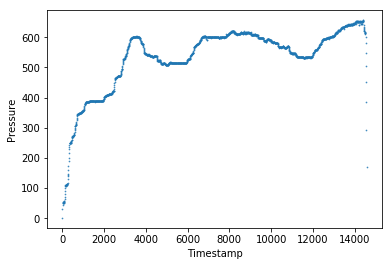

In [78]:
plot(f=parkinson_file_list[35],  plot_func=sns.regplot, t_id=0, x='Timestamp', y='Pressure')

#### Pressure (Control)

{'Precision': 0.4, 'Recall': 0.5714285714285714, 'F1': 0.47058823529411764}


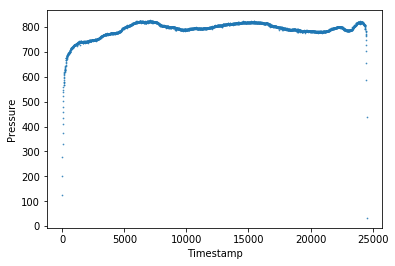

In [79]:
plot(control_file_list[1], plot_func=sns.regplot, t_id=0, x='Timestamp', y='Pressure')

{'Precision': 0.4, 'Recall': 0.5714285714285714, 'F1': 0.47058823529411764}


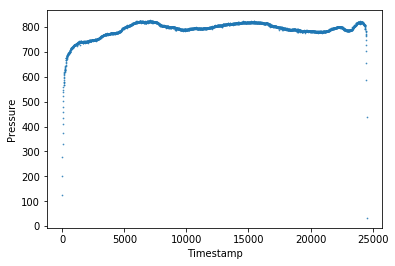

In [80]:
plot(control_file_list[1], plot_func=sns.regplot, t_id=0, x='Timestamp', y='Pressure')